In [ ]:
# notes that will save your time 
to save a model i train
import joblib

# Saving the model to not retrain later
joblib.dump(svm_1, "svm_1_v1.pkl")

# Load the model later
loaded_model = joblib.load("svm_1_v1.pkl")

# Make predictions with the loaded model
y_pred = loaded_model.predict(X1_test)
# to save tfidf vectorizations:
from scipy import sparse
import numpy as np
sparse.save_npz("./vectorizations/tfidf_v1/X1_train_tfidf.npz", X1_train)
sparse.save_npz("./vectorizations/tfidf_v1/X1_test_tfidf.npz", X1_test)
sparse.save_npz("./vectorizations/tfidf_v1/X1_val_tfidf.npz", X1_val)

# --- Save labels as numpy arrays ---
np.save("./vectorizations/tfidf_v1/y1_train_tfidf.npy", y1_train.to_numpy())
np.save("./vectorizations/tfidf_v1/y1_test_tfidf.npy", y1_test.to_numpy())
np.save("./vectorizations/tfidf_v1/y1_val_tfidf.npy", y1_val.to_numpy())





In [3]:
#personal issue with cuda..leave for me later
#i ran these commands:
#pip uninstall torch torchvision torchaudio -y -v
#pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu128 -v
#took some time and it worked, make sure the cuda version matches your gpu
import torch
# Verify CUDA is available
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("GPU count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

CUDA available: True
CUDA version: 12.8
GPU count: 1
GPU name: NVIDIA GeForce RTX 5080 Laptop GPU


**FIRST: Importing The Dataset**

We plan to use the exact same training, testing and validation elements. so we will import them from the same exact csv files to ensure fair and accurate comparison between the models.

In [1]:
import pandas as pd

train_df = pd.read_csv("../split_dataset/train_split.csv")
test_df = pd.read_csv("../split_dataset/test_split.csv")
val_df = pd.read_csv("../split_dataset/val_split.csv")

# Quick checks
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Validation shape:", val_df.shape)



Train shape: (126035, 4)
Test shape: (42012, 4)
Validation shape: (42012, 4)


**Support Vector Machines (SVM)** are a powerful supervised learning algorithm commonly used for classification tasks.

The main idea behinf SVM is to find a hyperplane that best seperates the classes in a high-dimensional feature space. This hyperplane will act as a decision boundary, and the algorithm selects the way that maximizes the *margin*, which is the distance between the hyperplane and the nearest points of each class. These points are called *support vectors*, and they are the most important data points since they "support" the position of the hyperplane, in other words, if these support vectors were changed or removed, the decision boundary would shift, while points farther away have little effect. -----

By focusing on the support vectors, SVM can generalize well to new, unseen data. This will be very benefitial to our project, which aims to detect phishing emails. 

we will try different preprocessing techniques on the datasets, as well as modify the paramaters of SVM in order to find the most suitable model for our project. 

the evaluation metrics of each model will be:
1. Accuracy
2. Precision
3. Recall
4. F1-score
5. confusion matrix

**Preprocessing Method #1: TF-IDF v1**

TF-IDF is one of the classic vectorization techniques when it comes to text. 
It is simple and fast, computationally cheaper, interpretable; as in you can see which words have the highest weight for a document.It can also reduce the impact of common words.
some cons to using TF-IDF: it ignores word order and context, which can heavily affect accuracy when it comes to predicting phishing/ spam emails. it can be sparse and high dimensional, for example, if we have 200k unique words, each email is a 200k dimensional sparse vector. which can be crazy to use for training, and storing in a databse.


`max_features` controls the vocabulary size, if it's too small it can lead to losing important information on some words, if it's too large we have the risk of overfitting and longer training time, with more memory consumption.
for `max_features`, a good balanced number is usually around 5k - 20k, therefore we will try to train using different numbers in this range. 

`stop_words` are common words like "the", "is", "of"...etc. They don't add much meaning in the classification process. having it can help with training accuracy by making the model focus on other, possibly more important words.
but there may be a risk where it can hurt the performance, therefore we will have a run not including it. 





**TF-IDF_v1**

For this run, we are using `stop_words = english` to remove the common mostly useless repetative words in the english language as explained before.
We are setting `max_features = 10000` for subject, since subjects usually tend to have less words than the body and we wish to only consider important words used in a phishing context. while for body we will take `max_features = 15000` as a start. 

*Notice: after we see the shape, it says 25000 columns, since we combined the subject and body vectors for this run.*

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
from scipy.sparse import hstack
import numpy as np

# --- TF-IDF Run #1  ---
vectorizer1_subject = TfidfVectorizer(
    max_features=10000,   
    stop_words="english"
)
vectorizer1_body = TfidfVectorizer(
    max_features=15000,  
    stop_words="english"
)

X1_train_subject = vectorizer1_subject.fit_transform(train_df["subject"].fillna(""))
X1_test_subject = vectorizer1_subject.transform(test_df["subject"].fillna(""))
X1_val_subject = vectorizer1_subject.transform(val_df["subject"].fillna(""))

X1_train_body = vectorizer1_body.fit_transform(train_df["body"].fillna(""))
X1_test_body = vectorizer1_body.transform(test_df["body"].fillna(""))
X1_val_body = vectorizer1_body.transform(val_df["body"].fillna(""))

# we combine subject and body vectors using hstack
X1_train = hstack([X1_train_subject, X1_train_body])
X1_test = hstack([X1_test_subject, X1_test_body])
X1_val = hstack([X1_val_subject, X1_val_body])


y1_train = train_df["isPhishing"]
y1_test = test_df["isPhishing"]
y1_val = val_df["isPhishing"]

print("Run 1 (TF-IDF separate subject+body) shapes:")
print("Train:", X1_train.shape, " Test:", X1_test.shape, " Val:", X1_val.shape)



sparse.save_npz("./vectorizations/tfidf_v1/X1_train_tfidf.npz", X1_train)
sparse.save_npz("./vectorizations/tfidf_v1/X1_test_tfidf.npz", X1_test)
sparse.save_npz("./vectorizations/tfidf_v1/X1_val_tfidf.npz", X1_val)

# --- Save labels as numpy arrays ---
np.save("./vectorizations/tfidf_v1/y1_train_tfidf.npy", y1_train.to_numpy())
np.save("./vectorizations/tfidf_v1/y1_test_tfidf.npy", y1_test.to_numpy())
np.save("./vectorizations/tfidf_v1/y1_val_tfidf.npy", y1_val.to_numpy())





Run 1 (TF-IDF separate subject+body) shapes:
Train: (126035, 25000)  Test: (42012, 25000)  Val: (42012, 25000)


In [2]:
#to load if u dont want to run it again:
from scipy import sparse
import numpy as np

X1_train = sparse.load_npz("./vectorizations/tfidf_v1/X1_train_tfidf.npz")
X1_test = sparse.load_npz("./vectorizations/tfidf_v1/X1_test_tfidf.npz")
X1_val = sparse.load_npz("./vectorizations/tfidf_v1/X1_val_tfidf.npz")

y1_train = np.load("./vectorizations/tfidf_v1/y1_train_tfidf.npy")
y1_test = np.load("./vectorizations/tfidf_v1/y1_test_tfidf.npy")
y1_val = np.load("./vectorizations/tfidf_v1/y1_val_tfidf.npy")

# --- Confirm everything loaded correctly ---
print("Loaded shapes:")
print("X_train:", X1_train.shape, " y_train:", y1_train.shape)
print("X_test:", X1_test.shape, " y_test:", y1_test.shape)
print("X_val:", X1_val.shape, " y_val:", y1_val.shape)

Loaded shapes:
X_train: (126035, 25000)  y_train: (126035,)
X_test: (42012, 25000)  y_test: (42012,)
X_val: (42012, 25000)  y_val: (42012,)


**SVM: Linear Run#1 Using TF-IDF_v1**

For this run, we will use linear SVC since we have a big dataset (a little over 200k emails).
`C` is the regulation paramater, it basically controls the tradeoff between:
1. Maximizing the margin: having a simpler model that is more generalizable; which can mean a less accurate model, that can be more likely to misclassify emails. and risk of having an underfitted model, since it wil allow some error in training.
2. Minimizing misclassification on training data: fitting training points closely; which can increase the risk of overfitting. 

`max_iter` is the maximum number of itterations the SVM solver will run while trying to find the optimal hyperplane. each iteration updates the model weights a little bit; after enough itterations the algorith, converges to a solution.
LinearSVC uses an iretative optimization algorith (typically *coordinate descent*) to minimize the SVM objective function. if the algorithm doesn't converge before `max_iter` iterations, it stops and throws a <u>**convergence warning**</u>. 
*If we donot get that error no point of increasing or changing the value of `max_iter`*. 

`random_state` is an important paramater for reproducibility. it's a seed for a random number generartior used by the algorith. since many parts of ML training involves randomness, such as initialization of weights, shuffling data for optimization, tie-breaking in SVM solver, it is important to have it so the run ( even with identical dataset) will produce the same result. which is important for comparing, experimenting and debugging later. 

we will choose `random_state= 42` for now.

the produced model will be `svm_1_v1.pkl`.

--- Training Metrics ---
Accuracy: 0.997468957035744
Precision: 0.9966831414919295
Recall: 0.9980761641673244
F1-score: 0.9973791664270397

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     65219
           1       1.00      1.00      1.00     60816

    accuracy                           1.00    126035
   macro avg       1.00      1.00      1.00    126035
weighted avg       1.00      1.00      1.00    126035



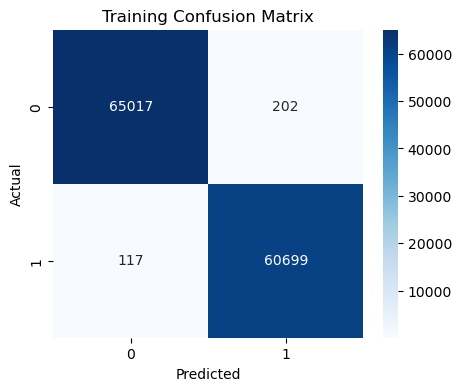

--- Test Metrics ---
Accuracy: 0.9812434542511663
Precision: 0.9777363672028246
Recall: 0.9835240726124704
F1-score: 0.9806216801101711

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     21740
           1       0.98      0.98      0.98     20272

    accuracy                           0.98     42012
   macro avg       0.98      0.98      0.98     42012
weighted avg       0.98      0.98      0.98     42012



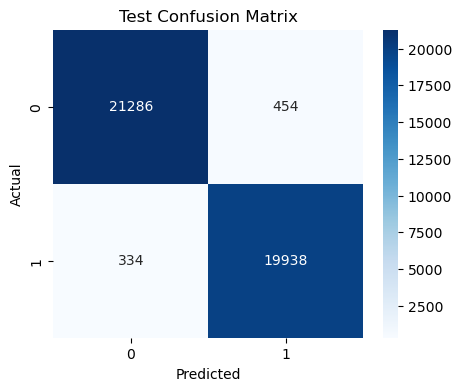

--- Validation Metrics ---
Accuracy: 0.982338379510616
Precision: 0.9801839012637066
Recall: 0.9832782518620826
F1-score: 0.9817286382664369

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     21739
           1       0.98      0.98      0.98     20273

    accuracy                           0.98     42012
   macro avg       0.98      0.98      0.98     42012
weighted avg       0.98      0.98      0.98     42012



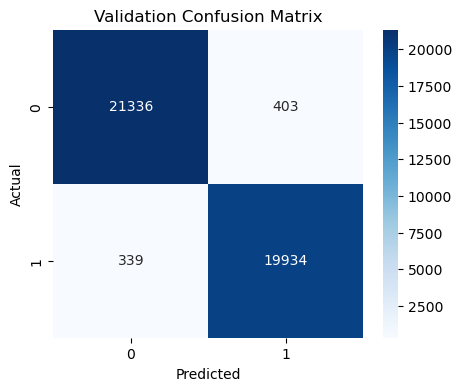

['./runs_models/run_1/vectorizer_body_1v1.pkl']

In [6]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


svm_1 = LinearSVC(
    C=1.0,  # Regularization parameter; 1.0 is default.
    max_iter=5000,   # you can increase to ensure convergence
    random_state=42
)


svm_1.fit(X1_train, y1_train)


y_train_pred = svm_1.predict(X1_train)
y_test_pred = svm_1.predict(X1_test)
y_val_pred = svm_1.predict(X1_val)

# --- Metrics function ---
def print_metrics(y_true, y_pred, dataset_name="Dataset"):
    print(f"--- {dataset_name} Metrics ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-score:", f1_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    
    # Confusion matrix plot
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.show()

# --- Print metrics for all splits ---
print_metrics(y1_train, y_train_pred, "Training")
print_metrics(y1_test, y_test_pred, "Test")
print_metrics(y1_val, y_val_pred, "Validation")
#save model
joblib.dump(svm_1, "./runs_models/run_1/svm_1_v1.pkl") 
joblib.dump(vectorizer1_subject, "./runs_models/run_1/vectorizer_subject_1v1.pkl")
joblib.dump(vectorizer1_body, "./runs_models/run_1/vectorizer_body_1v1.pkl")


The SVM model `svm_1_v1` excellent performance across all splits.

On the training set, the model reached an accuracy of approximately 99.75% with an F1-score of 99.73%, indicating it learned the patterns in the training data very well. On the unseen test and validation sets, the model maintained strong performance, achieving accuracies of 98.12% and 98.23% and F1-scores of 98.06% and 98.17%, respectively.

The slight drop from training to test and validation indicates a <u>minor degree of overfitting</u>, which is expected given the **high-dimensional TF-IDF features**. 

Overall, the high precision and recall across all splits suggest that the model is highly effective at correctly identifying both phishing and non-phishing emails, with very few false positives or false negatives. The results demonstrate that the model generalizes well to new data, and any minor overfitting could be further mitigated by slightly <u>reducing the regularization parameter C</u> or <u>limiting the number of TF-IDF features</u>.



**SVM: Linear Run#2 Using TF-IDF_v1**

The goal is to try and reduce the overfitting found in *SVM: Linear Run#1 TF-IDF_v1* by manipulating the value of the paramater `C`.

in this run, i will try trducing the value of `C` to `0.8` as an attempt to reduce the overfitting caused in *SVM: Linear Run#1 TF-IDF#1*.


the produced model will be `svm_1_v2.pkl`.

--- Training Metrics ---
Accuracy: 0.9970087674058793
Precision: 0.9960440570575007
Recall: 0.997763746382531
F1-score: 0.9969031600910159

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     65219
           1       1.00      1.00      1.00     60816

    accuracy                           1.00    126035
   macro avg       1.00      1.00      1.00    126035
weighted avg       1.00      1.00      1.00    126035



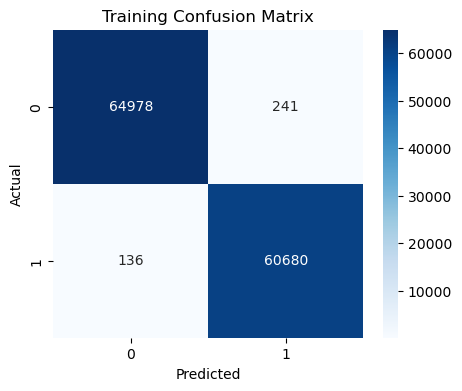

--- Test Metrics ---
Accuracy: 0.9814814814814815
Precision: 0.9779346866725508
Recall: 0.983820047355959
F1-score: 0.9808685388285053

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     21740
           1       0.98      0.98      0.98     20272

    accuracy                           0.98     42012
   macro avg       0.98      0.98      0.98     42012
weighted avg       0.98      0.98      0.98     42012



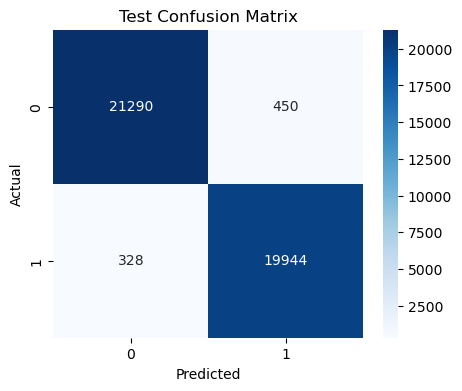

--- Validation Metrics ---
Accuracy: 0.9826954203560887
Precision: 0.9806235861119308
Recall: 0.9835742120061165
F1-score: 0.9820966828379344

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     21739
           1       0.98      0.98      0.98     20273

    accuracy                           0.98     42012
   macro avg       0.98      0.98      0.98     42012
weighted avg       0.98      0.98      0.98     42012



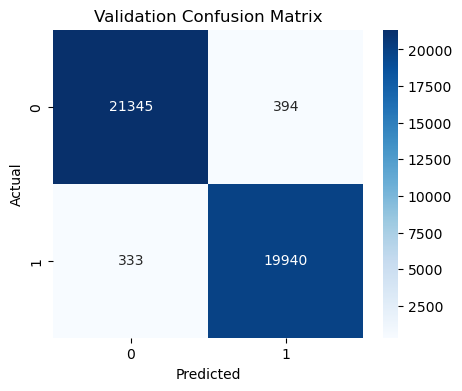

['./runs_models/run_1/vectorizer_body_1v2.pkl']

In [7]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


svm_1 = LinearSVC(
    C=0.8,  # Regularization parameter; 1.0 is default. 
    max_iter=5000,   # you can increase to ensure convergence
    random_state=42
)


svm_1.fit(X1_train, y1_train)


y_train_pred = svm_1.predict(X1_train)
y_test_pred = svm_1.predict(X1_test)
y_val_pred = svm_1.predict(X1_val)

# --- Metrics function ---
def print_metrics(y_true, y_pred, dataset_name="Dataset"):
    print(f"--- {dataset_name} Metrics ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-score:", f1_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    
    # Confusion matrix plot
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.show()

# --- Print metrics for all splits ---
print_metrics(y1_train, y_train_pred, "Training")
print_metrics(y1_test, y_test_pred, "Test")
print_metrics(y1_val, y_val_pred, "Validation")
#save model
joblib.dump(svm_1, "./runs_models/run_2/svm_1_v2.pkl")  
joblib.dump(vectorizer1_subject, "./runs_models/run_1/vectorizer_subject_1v2.pkl")
joblib.dump(vectorizer1_body, "./runs_models/run_1/vectorizer_body_1v2.pkl")

We see very similar results to *SVM: Linear Run#1 Using TF-IDF_v1*. 

So the value of C was not enough to reduce the overfitting by much, although the model is less overfitted now. 

let's try `C = 0.5`. 

--- Training Metrics ---
Accuracy: 0.9954853810449479
Precision: 0.9944682457609034
Recall: 0.9961852144172586
F1-score: 0.99532598963339

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     65219
           1       0.99      1.00      1.00     60816

    accuracy                           1.00    126035
   macro avg       1.00      1.00      1.00    126035
weighted avg       1.00      1.00      1.00    126035



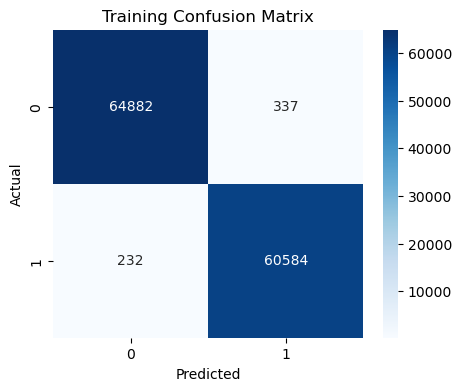

--- Test Metrics ---
Accuracy: 0.9819575359421118
Precision: 0.9782374277031664
Recall: 0.9845106550907656
F1-score: 0.981364016324925

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98     21740
           1       0.98      0.98      0.98     20272

    accuracy                           0.98     42012
   macro avg       0.98      0.98      0.98     42012
weighted avg       0.98      0.98      0.98     42012



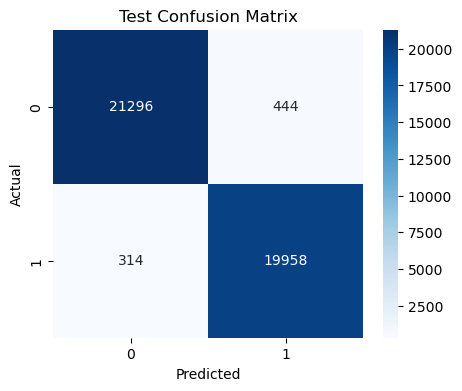

--- Validation Metrics ---
Accuracy: 0.9828620394173093
Precision: 0.9806302541664619
Recall: 0.9839194988408227
F1-score: 0.9822721229132811

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     21739
           1       0.98      0.98      0.98     20273

    accuracy                           0.98     42012
   macro avg       0.98      0.98      0.98     42012
weighted avg       0.98      0.98      0.98     42012



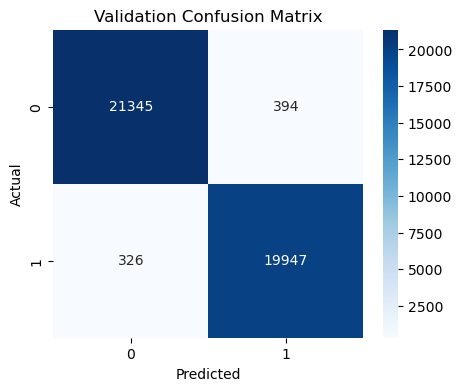

['./runs_models/run_1/vectorizer_body_1v2.pkl']

In [8]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


svm_1 = LinearSVC(
    C=0.5,  # Regularization parameter; 1.0 is default. 
    max_iter=5000,   # you can increase to ensure convergence
    random_state=42
)


svm_1.fit(X1_train, y1_train)


y_train_pred = svm_1.predict(X1_train)
y_test_pred = svm_1.predict(X1_test)
y_val_pred = svm_1.predict(X1_val)

# --- Metrics function ---
def print_metrics(y_true, y_pred, dataset_name="Dataset"):
    print(f"--- {dataset_name} Metrics ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-score:", f1_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    
    # Confusion matrix plot
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.show()

# --- Print metrics for all splits ---
print_metrics(y1_train, y_train_pred, "Training")
print_metrics(y1_test, y_test_pred, "Test")
print_metrics(y1_val, y_val_pred, "Validation")
#save model
joblib.dump(svm_1, "./runs_models/run_2/svm_1_v2.pkl") 
joblib.dump(vectorizer1_subject, "./runs_models/run_1/vectorizer_subject_1v2.pkl")
joblib.dump(vectorizer1_body, "./runs_models/run_1/vectorizer_body_1v2.pkl")

The results are still very similar to the *SVM: Linear Run#1 Using TF-IDF_v1*. it seems like the model is less overfitted but not by a much.
It isn't wise to go less with C, we do not want to be underfitting. nontheless, we will try another run wth `C=0.1`. 

--- Training Metrics ---
Accuracy: 0.988582536596977
Precision: 0.986083140953223
Recall: 0.9903150486714023
F1-score: 0.9881945640848941

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     65219
           1       0.99      0.99      0.99     60816

    accuracy                           0.99    126035
   macro avg       0.99      0.99      0.99    126035
weighted avg       0.99      0.99      0.99    126035



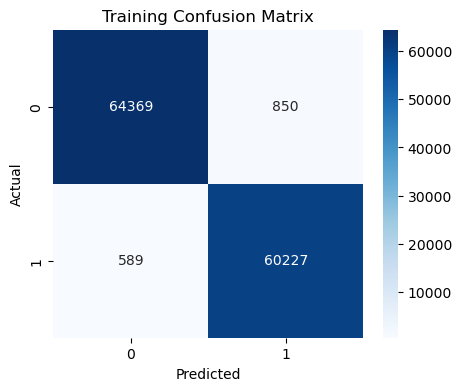

--- Test Metrics ---
Accuracy: 0.9802675426068742
Precision: 0.9761473282068864
Recall: 0.9831294396211523
F1-score: 0.9796259431295927

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     21740
           1       0.98      0.98      0.98     20272

    accuracy                           0.98     42012
   macro avg       0.98      0.98      0.98     42012
weighted avg       0.98      0.98      0.98     42012



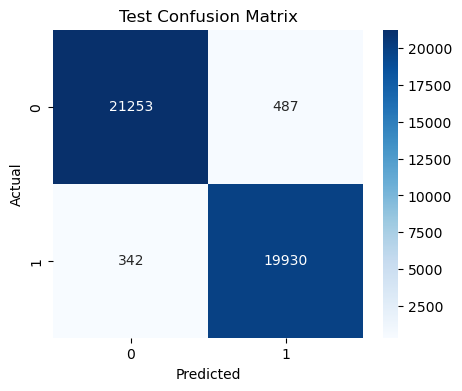

--- Validation Metrics ---
Accuracy: 0.9813148624202609
Precision: 0.978021978021978
Recall: 0.9833769052434272
F1-score: 0.9806921317362324

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     21739
           1       0.98      0.98      0.98     20273

    accuracy                           0.98     42012
   macro avg       0.98      0.98      0.98     42012
weighted avg       0.98      0.98      0.98     42012



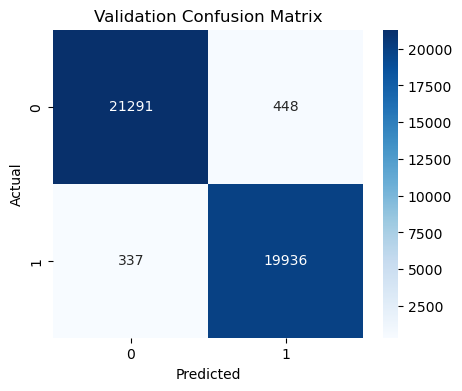

['./runs_models/run_1/vectorizer_body_1v2.pkl']

In [9]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


svm_1 = LinearSVC(
    C=0.1,  # Regularization parameter; 1.0 is default. 
    max_iter=5000,   # you can increase to ensure convergence
    random_state=42
)


svm_1.fit(X1_train, y1_train)


y_train_pred = svm_1.predict(X1_train)
y_test_pred = svm_1.predict(X1_test)
y_val_pred = svm_1.predict(X1_val)

# --- Metrics function ---
def print_metrics(y_true, y_pred, dataset_name="Dataset"):
    print(f"--- {dataset_name} Metrics ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-score:", f1_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    
    # Confusion matrix plot
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.show()

# --- Print metrics for all splits ---
print_metrics(y1_train, y_train_pred, "Training")
print_metrics(y1_test, y_test_pred, "Test")
print_metrics(y1_val, y_val_pred, "Validation")
#save model
joblib.dump(svm_1, "./runs_models/run_2/svm_1_v2.pkl") 
joblib.dump(vectorizer1_subject, "./runs_models/run_2/vectorizer_subject_1v2.pkl")
joblib.dump(vectorizer1_body, "./runs_models/run_2/vectorizer_body_1v2.pkl")

for the model trained with `C= 0.1`, we see that it has an accuracy of approximatly 98.86%, with an F1 score of 98.82%. On the test and validation sets, we see that the results have accuracies of 98.03% and 98.13% and F1-scores of 97.96% and 98.07%, respectively.

It seems that the new value of `C` managed to reduce overfitting, but at the cost of allowing the model to tollerate missclassification in the training data.

Still, the overall performance of the new model is still pretty good, it generalizes pretty well and produces high percision and recall across all splits.

The next logical step is to <u> modify some parmaters in the TF-IDF vectorization process</u>, and see if it will produce a more generalized model. 

**Preprocessing Method #1: TF-IDF v2**

[Combine subject and body to possibly reduce overfitting caused by having duplicate of key words]


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from scipy import sparse

# --- Combine subject + body into a single column ---
def combine_texts(df):
    return (df["subject"].fillna("") + " " + df["body"].fillna("")).str.strip()

train_texts = combine_texts(train_df)
test_texts = combine_texts(test_df)
val_texts = combine_texts(val_df)

# --- TF-IDF Vectorization ---
vectorizer2 = TfidfVectorizer(
    max_features=20000,  # combined, so sum of previous max_features
    stop_words="english"
)

X_train = vectorizer2.fit_transform(train_texts)
X_test = vectorizer2.transform(test_texts)
X_val = vectorizer2.transform(val_texts)

y_train = train_df["isPhishing"]
y_test = test_df["isPhishing"]
y_val = val_df["isPhishing"]

print("TF-IDF combined subject+body shapes:")
print("Train:", X_train.shape, " Test:", X_test.shape, " Val:", X_val.shape)

# --- Save embeddings ---
sparse.save_npz("./vectorizations/tfidf_v2/X_train_tfidf.npz", X_train)
sparse.save_npz("./vectorizations/tfidf_v2/X_test_tfidf.npz", X_test)
sparse.save_npz("./vectorizations/tfidf_v2/X_val_tfidf.npz", X_val)

# --- Save labels ---
np.save("./vectorizations/tfidf_v2/y_train_tfidf.npy", y_train.to_numpy())
np.save("./vectorizations/tfidf_v2/y_test_tfidf.npy", y_test.to_numpy())
np.save("./vectorizations/tfidf_v2/y_val_tfidf.npy", y_val.to_numpy())


TF-IDF combined subject+body shapes:
Train: (126035, 20000)  Test: (42012, 20000)  Val: (42012, 20000)


**SVM: Linear Run# 3 Using TF-IDF_v2**

[Add more info about the svm linear model]

--- Training Metrics ---
Accuracy: 0.9946284762169239
Precision: 0.9936790950434254
Recall: 0.9951986319389634
F1-score: 0.9944382830149928

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     65219
           1       0.99      1.00      0.99     60816

    accuracy                           0.99    126035
   macro avg       0.99      0.99      0.99    126035
weighted avg       0.99      0.99      0.99    126035



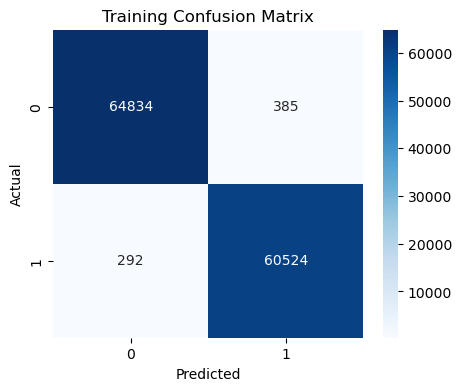

--- Test Metrics ---
Accuracy: 0.9812672569741978
Precision: 0.9775501200921524
Recall: 0.9837707182320442
F1-score: 0.9806505544218523

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     21740
           1       0.98      0.98      0.98     20272

    accuracy                           0.98     42012
   macro avg       0.98      0.98      0.98     42012
weighted avg       0.98      0.98      0.98     42012



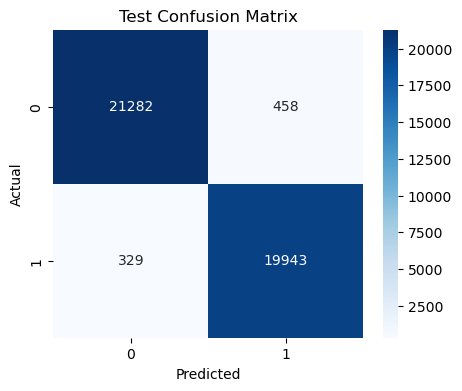

--- Validation Metrics ---
Accuracy: 0.9809578215747882
Precision: 0.9784285784482335
Recall: 0.9821930646672915
F1-score: 0.9803072075620323

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     21739
           1       0.98      0.98      0.98     20273

    accuracy                           0.98     42012
   macro avg       0.98      0.98      0.98     42012
weighted avg       0.98      0.98      0.98     42012



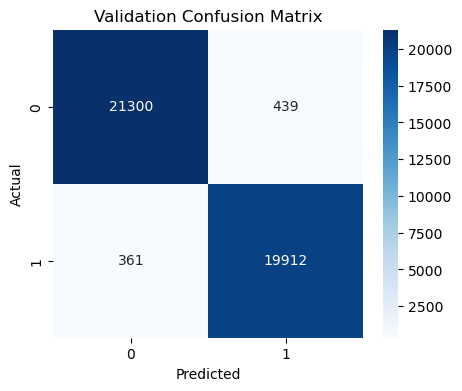

Model saved successfully!


In [12]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from scipy import sparse
import numpy as np

# --- Load saved TF-IDF embeddings if needed ---
X_train = sparse.load_npz("./vectorizations/tfidf_v2/X_train_tfidf.npz")
X_test = sparse.load_npz("./vectorizations/tfidf_v2/X_test_tfidf.npz")
X_val = sparse.load_npz("./vectorizations/tfidf_v2/X_val_tfidf.npz")
y_train = np.load("./vectorizations/tfidf_v2/y_train_tfidf.npy")
y_test = np.load("./vectorizations/tfidf_v2/y_test_tfidf.npy")
y_val = np.load("./vectorizations/tfidf_v2/y_val_tfidf.npy")

svm_1 = LinearSVC(
    C=1.0,          
    max_iter=5000,  
    random_state=42
)


svm_1.fit(X_train, y_train)

# --- Predict on all splits ---
y_train_pred = svm_1.predict(X_train)
y_test_pred  = svm_1.predict(X_test)
y_val_pred   = svm_1.predict(X_val)

# --- Metrics function ---
def print_metrics(y_true, y_pred, dataset_name="Dataset"):
    print(f"--- {dataset_name} Metrics ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-score:", f1_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    
    # Confusion matrix plot
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.show()

# --- Print metrics for all splits ---
print_metrics(y_train, y_train_pred, "Training")
print_metrics(y_test, y_test_pred, "Test")
print_metrics(y_val, y_val_pred, "Validation")

# --- Save trained SVM model ---
joblib.dump(svm_1, "./runs_models/run_3/svm_1_v3.pkl")
joblib.dump(vectorizer2, "./runs_models/run_3/vectorizer2.pkl")
print("Model saved successfully!")


[Notice how overfitting is less than before, still might be overfitted? look into it]

[conclude why you think tfidf is horrible, no context, doesnt care about order, likely to cause overfitting]

**Preprocessing Method #2: SBERT v1**

[Describe SBIRT]

[Why you plan to use it]

[Talk about the issue caused by Nan values in the subject most likely]
[also device = device in model encode]

[say you fixed it with this function]

In [6]:
from sentence_transformers import SentenceTransformer
import torch
import numpy as np
import pandas as pd

# Load model
model = SentenceTransformer('paraphrase-mpnet-base-v2')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
print("Using device:", device)

# Combine subject + body and handle NaN values
def combine_texts(df):
    # Fill NaN with empty string first
    subject = df["subject"].fillna("")
    body = df["body"].fillna("")
    # Combine
    texts = subject + " " + body
    # Strip whitespace and replace empty strings with a placeholder
    texts = texts.str.strip()
    texts = texts.replace("", "empty")  # or use "no content"
    return texts

train_texts = combine_texts(train_df)
test_texts = combine_texts(test_df)
val_texts = combine_texts(val_df)

# Check for any remaining issues
print(f"Train texts with NaN: {train_texts.isna().sum()}")
#print(f"Sample train text: {train_texts.iloc[0]}")

# Encode - REMOVE the device parameter
X_train_sbert = model.encode(train_texts.tolist(), batch_size=64, show_progress_bar=True)
X_test_sbert  = model.encode(test_texts.tolist(), batch_size=64, show_progress_bar=True)
X_val_sbert   = model.encode(val_texts.tolist(), batch_size=64, show_progress_bar=True)

# Labels
y_train_sbert = train_df["isPhishing"]
y_test_sbert  = test_df["isPhishing"]
y_val_sbert   = val_df["isPhishing"]

print("Train embeddings shape:", X_train_sbert.shape)
print("Test embeddings shape:", X_test_sbert.shape)
print("Validation embeddings shape:", X_val_sbert.shape)

# Save embeddings
np.save('./vectorizations/sbert_v1/X_train_sbert.npy', X_train_sbert)
np.save('./vectorizations/sbert_v1/X_test_sbert.npy', X_test_sbert)
np.save('./vectorizations/sbert_v1/X_val_sbert.npy', X_val_sbert)

# Save labels
np.save('./vectorizations/sbert_v1/y_train_sbert.npy', y_train_sbert.to_numpy())
np.save('./vectorizations/sbert_v1/y_test_sbert.npy', y_test_sbert.to_numpy())
np.save('./vectorizations/sbert_v1/y_val_sbert.npy', y_val_sbert.to_numpy())

Using device: cuda
Train texts with NaN: 0


Batches:   0%|          | 0/1970 [00:00<?, ?it/s]

Batches:   0%|          | 0/657 [00:00<?, ?it/s]

Batches:   0%|          | 0/657 [00:00<?, ?it/s]

Train embeddings shape: (126035, 768)
Test embeddings shape: (42012, 768)
Validation embeddings shape: (42012, 768)


In [13]:
#to load later:
print("Loading SBERT embeddings...")
X_train_sbert = np.load('./vectorizations/sbert_v1/X_train_sbert.npy')
X_test_sbert = np.load('./vectorizations/sbert_v1/X_test_sbert.npy')
X_val_sbert = np.load('./vectorizations/sbert_v1/X_val_sbert.npy')

# Load labels
y_train_sbert = np.load('./vectorizations/sbert_v1/y_train_sbert.npy')
y_test_sbert = np.load('./vectorizations/sbert_v1/y_test_sbert.npy')
y_val_sbert = np.load('./vectorizations/sbert_v1/y_val_sbert.npy')

print(f"Train shape: {X_train_sbert.shape}")
print(f"Test shape: {X_test_sbert.shape}")
print(f"Validation shape: {X_val_sbert.shape}")


Loading SBERT embeddings...
Train shape: (126035, 768)
Test shape: (42012, 768)
Validation shape: (42012, 768)


**SVM: Linear Run#4 Using SBERT_v1**

[talk about what you will do for training here]



Shapes:
Train: (126035, 768)
Test: (42012, 768)
Val: (42012, 768)
Training LinearSVC on SBERT embeddings...
Training complete!

--- Training Metrics ---
Accuracy : 0.9749990082120046
Precision: 0.9735567052640224
Recall   : 0.9746612733491187
F1-score : 0.9741086761817898

Classification Report:
               precision    recall  f1-score   support

           0     0.9763    0.9753    0.9758     65219
           1     0.9736    0.9747    0.9741     60816

    accuracy                         0.9750    126035
   macro avg     0.9750    0.9750    0.9750    126035
weighted avg     0.9750    0.9750    0.9750    126035



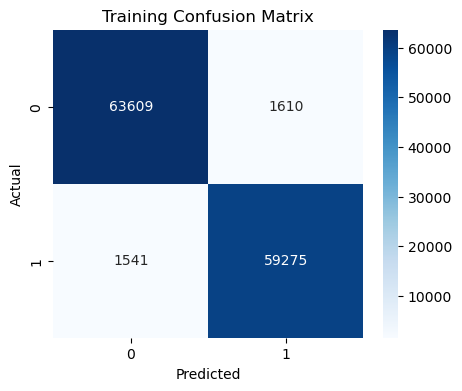


--- Test Metrics ---
Accuracy : 0.973507569265924
Precision: 0.97219894513728
Recall   : 0.9729183109707972
F1-score : 0.9725584950319288

Classification Report:
               precision    recall  f1-score   support

           0     0.9747    0.9741    0.9744     21740
           1     0.9722    0.9729    0.9726     20272

    accuracy                         0.9735     42012
   macro avg     0.9735    0.9735    0.9735     42012
weighted avg     0.9735    0.9735    0.9735     42012



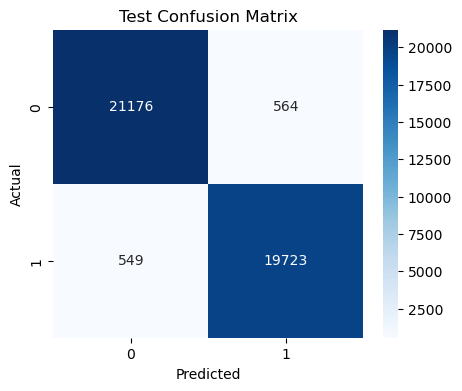


--- Validation Metrics ---
Accuracy : 0.9716509568694659
Precision: 0.9706956092747904
Recall   : 0.9705519656686233
F1-score : 0.9706237821572158

Classification Report:
               precision    recall  f1-score   support

           0     0.9725    0.9727    0.9726     21739
           1     0.9707    0.9706    0.9706     20273

    accuracy                         0.9717     42012
   macro avg     0.9716    0.9716    0.9716     42012
weighted avg     0.9717    0.9717    0.9717     42012



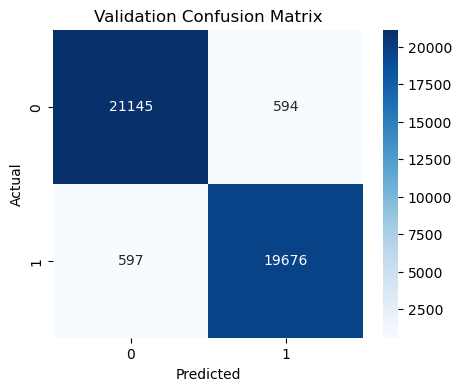

 Model saved at ./runs_models/run_4/svm_2_v1.pkl


In [15]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

#trying to see if loading works
X_train = np.load('./vectorizations/sbert_v1/X_train_sbert.npy')
X_test  = np.load('./vectorizations/sbert_v1/X_test_sbert.npy')
X_val   = np.load('./vectorizations/sbert_v1/X_val_sbert.npy')

y_train = np.load('./vectorizations/sbert_v1/y_train_sbert.npy')
y_test  = np.load('./vectorizations/sbert_v1/y_test_sbert.npy')
y_val   = np.load('./vectorizations/sbert_v1/y_val_sbert.npy')

print("Shapes:")
print("Train:", X_train.shape)
print("Test:", X_test.shape)
print("Val:", X_val.shape)


svm_2 = LinearSVC(
    C=1.0,              
    max_iter=5000,     
    random_state=42
)


print("Training LinearSVC on SBERT embeddings...")
svm_2.fit(X_train, y_train)
print("Training complete!")

# === Predictions ===
y_train_pred = svm_2.predict(X_train)
y_test_pred  = svm_2.predict(X_test)
y_val_pred   = svm_2.predict(X_val)

# === Metrics function ===
def print_metrics(y_true, y_pred, dataset_name="Dataset"):
    print(f"\n--- {dataset_name} Metrics ---")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1-score :", f1_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.show()

# === Evaluate ===
print_metrics(y_train, y_train_pred, "Training")
print_metrics(y_test, y_test_pred, "Test")
print_metrics(y_val, y_val_pred, "Validation")


joblib.dump(svm_2, "./runs_models/run_4/svm_2_v1.pkl")
print(" Model saved at ./runs_models/run_4/svm_2_v1.pkl")


[Speak about results here]

[doesnt seem to be overfitted, maybe theres a technique to verify this]

[how to improve????]

**Preprocessing Method #2: SBERT v2**

[talk about the lighter DL model you will use for this run: all-MiniLM-L6-v2]




In [9]:
from sentence_transformers import SentenceTransformer
import torch
import numpy as np
import pandas as pd

# Load model
model = SentenceTransformer('all-MiniLM-L6-v2')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
print("Using device:", device)

# Combine subject + body and handle NaN values
def combine_texts(df):
    # Fill NaN with empty string first
    subject = df["subject"].fillna("")
    body = df["body"].fillna("")
    # Combine
    texts = subject + " " + body
    # Strip whitespace and replace empty strings with a placeholder
    texts = texts.str.strip()
    texts = texts.replace("", "empty")  # or use "no content"
    return texts

train_texts = combine_texts(train_df)
test_texts = combine_texts(test_df)
val_texts = combine_texts(val_df)

# Check for any remaining issues
print(f"Train texts with NaN: {train_texts.isna().sum()}")
#print(f"Sample train text: {train_texts.iloc[0]}")

# Encode - REMOVE the device parameter
X_train_sbert = model.encode(train_texts.tolist(), batch_size=64, show_progress_bar=True)
X_test_sbert  = model.encode(test_texts.tolist(), batch_size=64, show_progress_bar=True)
X_val_sbert   = model.encode(val_texts.tolist(), batch_size=64, show_progress_bar=True)

# Labels
y_train_sbert = train_df["isPhishing"]
y_test_sbert  = test_df["isPhishing"]
y_val_sbert   = val_df["isPhishing"]

print("Train embeddings shape:", X_train_sbert.shape)
print("Test embeddings shape:", X_test_sbert.shape)
print("Validation embeddings shape:", X_val_sbert.shape)

# Save embeddings
np.save('./vectorizations/sbert_v2/X_train_sbert.npy', X_train_sbert)
np.save('./vectorizations/sbert_v2/X_test_sbert.npy', X_test_sbert)
np.save('./vectorizations/sbert_v2/X_val_sbert.npy', X_val_sbert)

# Save labels
np.save('./vectorizations/sbert_v2/y_train_sbert.npy', y_train_sbert.to_numpy())
np.save('./vectorizations/sbert_v2/y_test_sbert.npy', y_test_sbert.to_numpy())
np.save('./vectorizations/sbert_v2/y_val_sbert.npy', y_val_sbert.to_numpy())

Using device: cuda
Train texts with NaN: 0


Batches:   0%|          | 0/1970 [00:00<?, ?it/s]

Batches:   0%|          | 0/657 [00:00<?, ?it/s]

Batches:   0%|          | 0/657 [00:00<?, ?it/s]

Train embeddings shape: (126035, 384)
Test embeddings shape: (42012, 384)
Validation embeddings shape: (42012, 384)


**SVM: Linear Run#5 Using SBERT_v2**

[Explain a bit about what is happening here]

Shapes:
Train: (126035, 384)
Test: (42012, 384)
Val: (42012, 384)
Training LinearSVC on SBERT embeddings...
Training complete!

--- Training Metrics ---
Accuracy : 0.9492125203316539
Precision: 0.9480149516705363
Recall   : 0.9466587740068403
F1-score : 0.9473363774733637

Classification Report:
               precision    recall  f1-score   support

           0     0.9503    0.9516    0.9510     65219
           1     0.9480    0.9467    0.9473     60816

    accuracy                         0.9492    126035
   macro avg     0.9492    0.9491    0.9491    126035
weighted avg     0.9492    0.9492    0.9492    126035



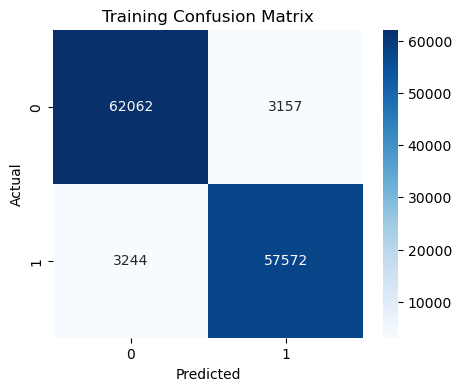


--- Test Metrics ---
Accuracy : 0.9480386556222031
Precision: 0.947282528064883
Recall   : 0.9448993685872139
F1-score : 0.9460894475588373

Classification Report:
               precision    recall  f1-score   support

           0     0.9487    0.9510    0.9499     21740
           1     0.9473    0.9449    0.9461     20272

    accuracy                         0.9480     42012
   macro avg     0.9480    0.9479    0.9480     42012
weighted avg     0.9480    0.9480    0.9480     42012



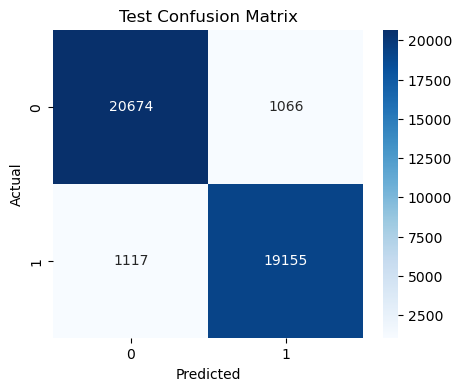


--- Validation Metrics ---
Accuracy : 0.9483242882985814
Precision: 0.9486467730742539
Recall   : 0.9440142060869137
F1-score : 0.9463248201349914

Classification Report:
               precision    recall  f1-score   support

           0     0.9480    0.9523    0.9502     21739
           1     0.9486    0.9440    0.9463     20273

    accuracy                         0.9483     42012
   macro avg     0.9483    0.9482    0.9483     42012
weighted avg     0.9483    0.9483    0.9483     42012



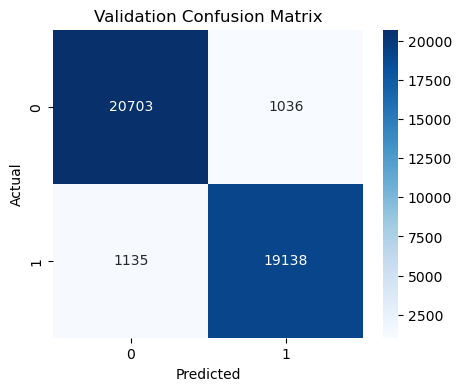

 Model saved at ./runs_models/run_5/svm_2_v2.pkl


In [17]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

#trying to see if loading works
X_train = np.load('./vectorizations/sbert_v2/X_train_sbert.npy')
X_test  = np.load('./vectorizations/sbert_v2/X_test_sbert.npy')
X_val   = np.load('./vectorizations/sbert_v2/X_val_sbert.npy')

y_train = np.load('./vectorizations/sbert_v2/y_train_sbert.npy')
y_test  = np.load('./vectorizations/sbert_v2/y_test_sbert.npy')
y_val   = np.load('./vectorizations/sbert_v2/y_val_sbert.npy')

print("Shapes:")
print("Train:", X_train.shape)
print("Test:", X_test.shape)
print("Val:", X_val.shape)


svm_2 = LinearSVC(
    C=1.0,              
    max_iter=5000,     
    random_state=42
)


print("Training LinearSVC on SBERT embeddings...")
svm_2.fit(X_train, y_train)
print("Training complete!")

# === Predictions ===
y_train_pred = svm_2.predict(X_train)
y_test_pred  = svm_2.predict(X_test)
y_val_pred   = svm_2.predict(X_val)

# === Metrics function ===
def print_metrics(y_true, y_pred, dataset_name="Dataset"):
    print(f"\n--- {dataset_name} Metrics ---")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1-score :", f1_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.show()

# === Evaluate ===
print_metrics(y_train, y_train_pred, "Training")
print_metrics(y_test, y_test_pred, "Test")
print_metrics(y_val, y_val_pred, "Validation")


joblib.dump(svm_2, "./runs_models/run_5/svm_2_v2.pkl")
print(" Model saved at ./runs_models/run_5/svm_2_v2.pkl")

[discuss results, doesnt seem to be overfitted]

[Discuss why the lighter one might be better for the app, look into ways to improve accuracy]

[ increase C to 1.5 for starters] 

Shapes:
Train: (126035, 384)
Test: (42012, 384)
Val: (42012, 384)
Training LinearSVC on SBERT embeddings...
Training complete!

--- Training Metrics ---
Accuracy : 0.9492363232435435
Precision: 0.9480470293768937
Recall   : 0.9466752170481453
F1-score : 0.9473606266043573

Classification Report:
               precision    recall  f1-score   support

           0     0.9503    0.9516    0.9510     65219
           1     0.9480    0.9467    0.9474     60816

    accuracy                         0.9492    126035
   macro avg     0.9492    0.9491    0.9492    126035
weighted avg     0.9492    0.9492    0.9492    126035



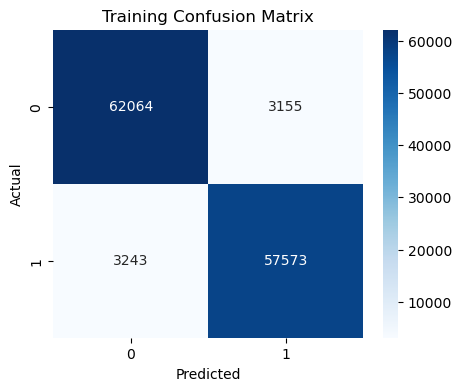


--- Test Metrics ---
Accuracy : 0.9481338665143293
Precision: 0.9473371903278446
Recall   : 0.9450473559589582
F1-score : 0.9461908877639215

Classification Report:
               precision    recall  f1-score   support

           0     0.9489    0.9510    0.9499     21740
           1     0.9473    0.9450    0.9462     20272

    accuracy                         0.9481     42012
   macro avg     0.9481    0.9480    0.9481     42012
weighted avg     0.9481    0.9481    0.9481     42012



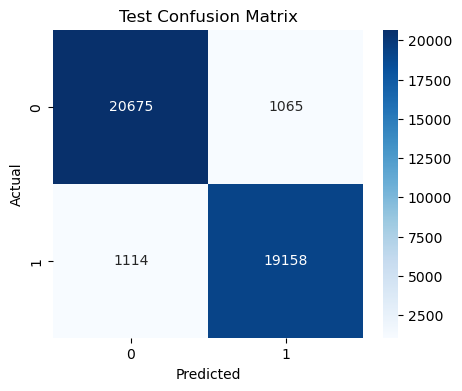


--- Validation Metrics ---
Accuracy : 0.9483718937446444
Precision: 0.9486518636003172
Recall   : 0.9441128594682583
F1-score : 0.94637691908329

Classification Report:
               precision    recall  f1-score   support

           0     0.9481    0.9523    0.9502     21739
           1     0.9487    0.9441    0.9464     20273

    accuracy                         0.9484     42012
   macro avg     0.9484    0.9482    0.9483     42012
weighted avg     0.9484    0.9484    0.9484     42012



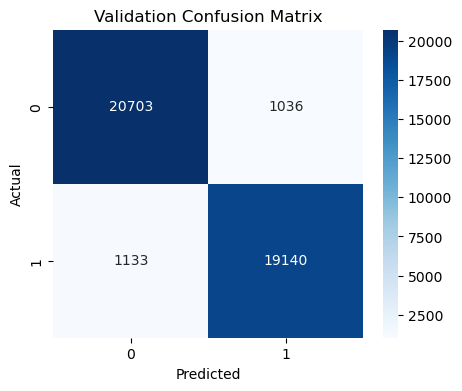

 Model saved at ./runs_models/run_5/svm_2_v3.pkl


In [20]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

#trying to see if loading works
X_train = np.load('./vectorizations/sbert_v2/X_train_sbert.npy')
X_test  = np.load('./vectorizations/sbert_v2/X_test_sbert.npy')
X_val   = np.load('./vectorizations/sbert_v2/X_val_sbert.npy')

y_train = np.load('./vectorizations/sbert_v2/y_train_sbert.npy')
y_test  = np.load('./vectorizations/sbert_v2/y_test_sbert.npy')
y_val   = np.load('./vectorizations/sbert_v2/y_val_sbert.npy')

print("Shapes:")
print("Train:", X_train.shape)
print("Test:", X_test.shape)
print("Val:", X_val.shape)


svm_2 = LinearSVC(
    C=1.5,              
    max_iter=5000,     
    random_state=42
)


print("Training LinearSVC on SBERT embeddings...")
svm_2.fit(X_train, y_train)
print("Training complete!")

# === Predictions ===
y_train_pred = svm_2.predict(X_train)
y_test_pred  = svm_2.predict(X_test)
y_val_pred   = svm_2.predict(X_val)

# === Metrics function ===
def print_metrics(y_true, y_pred, dataset_name="Dataset"):
    print(f"\n--- {dataset_name} Metrics ---")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1-score :", f1_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.show()

# === Evaluate ===
print_metrics(y_train, y_train_pred, "Training")
print_metrics(y_test, y_test_pred, "Test")
print_metrics(y_val, y_val_pred, "Validation")


joblib.dump(svm_2, "./runs_models/run_5/svm_2_v3.pkl")
print(" Model saved at ./runs_models/run_5/svm_2_v3.pkl")

[No much difference, increase more?]

[ C increased to C]

Shapes:
Train: (126035, 384)
Test: (42012, 384)
Val: (42012, 384)
Training LinearSVC on SBERT embeddings...
Training complete!

--- Training Metrics ---
Accuracy : 0.9492125203316539
Precision: 0.948103496549566
Recall   : 0.9465601157590108
F1-score : 0.9473311775402565

Classification Report:
               precision    recall  f1-score   support

           0     0.9502    0.9517    0.9510     65219
           1     0.9481    0.9466    0.9473     60816

    accuracy                         0.9492    126035
   macro avg     0.9492    0.9491    0.9491    126035
weighted avg     0.9492    0.9492    0.9492    126035



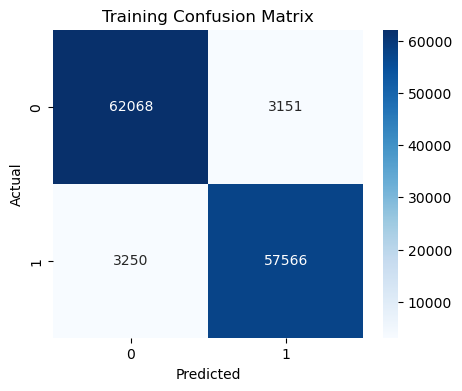


--- Test Metrics ---
Accuracy : 0.9480862610682662
Precision: 0.9472435105067986
Recall   : 0.9450473559589582
F1-score : 0.9461441588265798

Classification Report:
               precision    recall  f1-score   support

           0     0.9489    0.9509    0.9499     21740
           1     0.9472    0.9450    0.9461     20272

    accuracy                         0.9481     42012
   macro avg     0.9481    0.9480    0.9480     42012
weighted avg     0.9481    0.9481    0.9481     42012



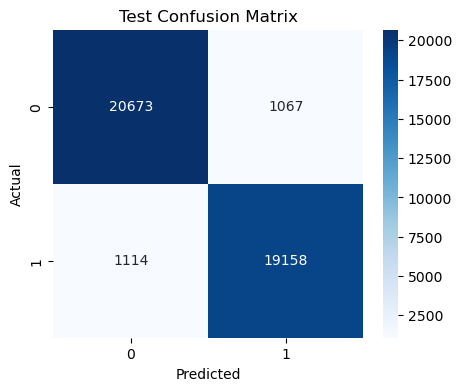


--- Validation Metrics ---
Accuracy : 0.9480624583452347
Precision: 0.9484408308958405
Recall   : 0.9436689192522074
F1-score : 0.9460488576797548

Classification Report:
               precision    recall  f1-score   support

           0     0.9477    0.9522    0.9499     21739
           1     0.9484    0.9437    0.9460     20273

    accuracy                         0.9481     42012
   macro avg     0.9481    0.9479    0.9480     42012
weighted avg     0.9481    0.9481    0.9481     42012



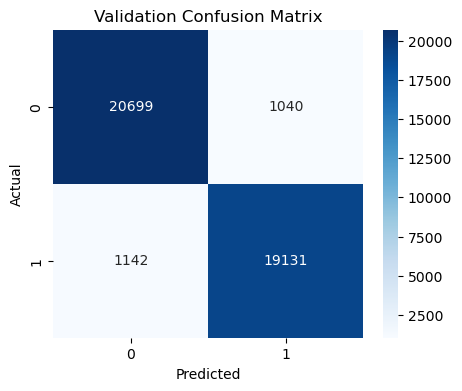

 Model saved at ./runs_models/run_5/svm_2_v4.pkl


In [19]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

#trying to see if loading works
X_train = np.load('./vectorizations/sbert_v2/X_train_sbert.npy')
X_test  = np.load('./vectorizations/sbert_v2/X_test_sbert.npy')
X_val   = np.load('./vectorizations/sbert_v2/X_val_sbert.npy')

y_train = np.load('./vectorizations/sbert_v2/y_train_sbert.npy')
y_test  = np.load('./vectorizations/sbert_v2/y_test_sbert.npy')
y_val   = np.load('./vectorizations/sbert_v2/y_val_sbert.npy')

print("Shapes:")
print("Train:", X_train.shape)
print("Test:", X_test.shape)
print("Val:", X_val.shape)


svm_2 = LinearSVC(
    C=3.0,              
    max_iter=5000,     
    random_state=42
)


print("Training LinearSVC on SBERT embeddings...")
svm_2.fit(X_train, y_train)
print("Training complete!")

# === Predictions ===
y_train_pred = svm_2.predict(X_train)
y_test_pred  = svm_2.predict(X_test)
y_val_pred   = svm_2.predict(X_val)

# === Metrics function ===
def print_metrics(y_true, y_pred, dataset_name="Dataset"):
    print(f"\n--- {dataset_name} Metrics ---")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1-score :", f1_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.show()

# === Evaluate ===
print_metrics(y_train, y_train_pred, "Training")
print_metrics(y_test, y_test_pred, "Test")
print_metrics(y_val, y_val_pred, "Validation")


joblib.dump(svm_2, "./runs_models/run_5/svm_2_v4.pkl")
print(" Model saved at ./runs_models/run_5/svm_2_v4.pkl")

[somehow made worst]

[maybe there's an sbert model between the previous 2?]

**Preprocessing Method #2: SBERT v3**

[[paraphrase-distilroberta-base-v2] trying this model of sbert]

[it is not as accurate as the first, but still faster. (paraphrase-mpnet-base-v2)]

[more accurate than (all-MiniLM-L6-v2), and slightly slower]


In [14]:
from sentence_transformers import SentenceTransformer
import torch
import numpy as np
import pandas as pd

# Load model
model = SentenceTransformer('paraphrase-distilroberta-base-v2')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
print("Using device:", device)

# Combine subject + body and handle NaN values
def combine_texts(df):
    # Fill NaN with empty string first
    subject = df["subject"].fillna("")
    body = df["body"].fillna("")
    # Combine
    texts = subject + " " + body
    # Strip whitespace and replace empty strings with a placeholder
    texts = texts.str.strip()
    texts = texts.replace("", "empty")  # or use "no content"
    return texts

train_texts = combine_texts(train_df)
test_texts = combine_texts(test_df)
val_texts = combine_texts(val_df)

# Check for any remaining issues
print(f"Train texts with NaN: {train_texts.isna().sum()}")
#print(f"Sample train text: {train_texts.iloc[0]}")

# Encode - REMOVE the device parameter
X_train_sbert = model.encode(train_texts.tolist(), batch_size=64, show_progress_bar=True)
X_test_sbert  = model.encode(test_texts.tolist(), batch_size=64, show_progress_bar=True)
X_val_sbert   = model.encode(val_texts.tolist(), batch_size=64, show_progress_bar=True)

# Labels
y_train_sbert = train_df["isPhishing"]
y_test_sbert  = test_df["isPhishing"]
y_val_sbert   = val_df["isPhishing"]

print("Train embeddings shape:", X_train_sbert.shape)
print("Test embeddings shape:", X_test_sbert.shape)
print("Validation embeddings shape:", X_val_sbert.shape)

# Save embeddings
np.save('./vectorizations/sbert_v3/X_train_sbert.npy', X_train_sbert)
np.save('./vectorizations/sbert_v3/X_test_sbert.npy', X_test_sbert)
np.save('./vectorizations/sbert_v3/X_val_sbert.npy', X_val_sbert)

# Save labels
np.save('./vectorizations/sbert_v3/y_train_sbert.npy', y_train_sbert.to_numpy())
np.save('./vectorizations/sbert_v3/y_test_sbert.npy', y_test_sbert.to_numpy())
np.save('./vectorizations/sbert_v3/y_val_sbert.npy', y_val_sbert.to_numpy())

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

C:\Users\omark\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\omark\.cache\huggingface\hub\models--sentence-transformers--paraphrase-distilroberta-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Using device: cuda
Train texts with NaN: 0


Batches:   0%|          | 0/1970 [00:00<?, ?it/s]

Batches:   0%|          | 0/657 [00:00<?, ?it/s]

Batches:   0%|          | 0/657 [00:00<?, ?it/s]

Train embeddings shape: (126035, 768)
Test embeddings shape: (42012, 768)
Validation embeddings shape: (42012, 768)


**SVM: Linear Run#6 Using SBERT_v3**

[talk a bit]

Shapes:
Train: (126035, 768)
Test: (42012, 768)
Val: (42012, 768)
Training LinearSVC on SBERT embeddings...
Training complete!

--- Training Metrics ---
Accuracy : 0.9711191335740073
Precision: 0.9694715407100863
Recall   : 0.9707149434359379
F1-score : 0.9700928436447293

Classification Report:
               precision    recall  f1-score   support

           0     0.9727    0.9715    0.9721     65219
           1     0.9695    0.9707    0.9701     60816

    accuracy                         0.9711    126035
   macro avg     0.9711    0.9711    0.9711    126035
weighted avg     0.9711    0.9711    0.9711    126035



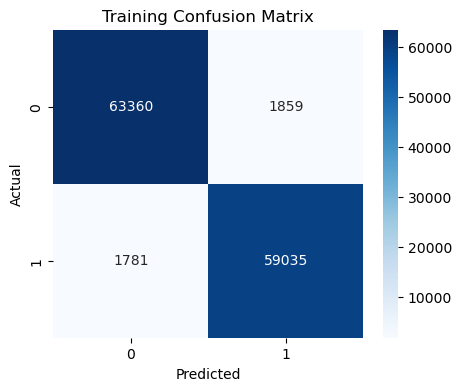


--- Test Metrics ---
Accuracy : 0.9690088546129677
Precision: 0.9665977961432507
Recall   : 0.9692679558011049
F1-score : 0.9679310344827586

Classification Report:
               precision    recall  f1-score   support

           0     0.9713    0.9688    0.9700     21740
           1     0.9666    0.9693    0.9679     20272

    accuracy                         0.9690     42012
   macro avg     0.9689    0.9690    0.9690     42012
weighted avg     0.9690    0.9690    0.9690     42012



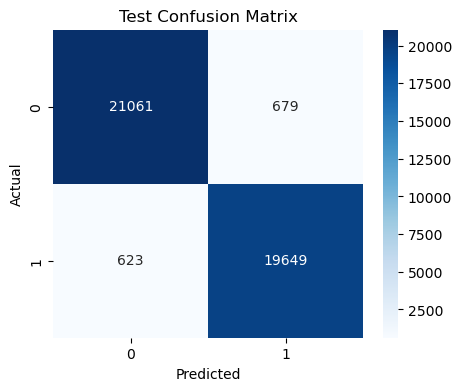


--- Validation Metrics ---
Accuracy : 0.9684137865371798
Precision: 0.9666042754408433
Recall   : 0.9679869777536625
F1-score : 0.9672951324707332

Classification Report:
               precision    recall  f1-score   support

           0     0.9701    0.9688    0.9695     21739
           1     0.9666    0.9680    0.9673     20273

    accuracy                         0.9684     42012
   macro avg     0.9684    0.9684    0.9684     42012
weighted avg     0.9684    0.9684    0.9684     42012



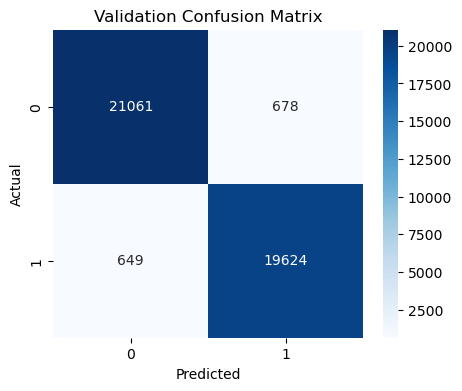

NameError: name 'svm_sbert' is not defined

In [23]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

#trying to see if loading works
X_train = np.load('./vectorizations/sbert_v3/X_train_sbert.npy')
X_test  = np.load('./vectorizations/sbert_v3/X_test_sbert.npy')
X_val   = np.load('./vectorizations/sbert_v3/X_val_sbert.npy')

y_train = np.load('./vectorizations/sbert_v3/y_train_sbert.npy')
y_test  = np.load('./vectorizations/sbert_v3/y_test_sbert.npy')
y_val   = np.load('./vectorizations/sbert_v3/y_val_sbert.npy')

print("Shapes:")
print("Train:", X_train.shape)
print("Test:", X_test.shape)
print("Val:", X_val.shape)


svm_2 = LinearSVC(
    C=1.0,              
    max_iter=5000,     
    random_state=42
)


print("Training LinearSVC on SBERT embeddings...")
svm_2.fit(X_train, y_train)
print("Training complete!")

# === Predictions ===
y_train_pred = svm_2.predict(X_train)
y_test_pred  = svm_2.predict(X_test)
y_val_pred   = svm_2.predict(X_val)

# === Metrics function ===
def print_metrics(y_true, y_pred, dataset_name="Dataset"):
    print(f"\n--- {dataset_name} Metrics ---")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1-score :", f1_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.show()

# === Evaluate ===
print_metrics(y_train, y_train_pred, "Training")
print_metrics(y_test, y_test_pred, "Test")
print_metrics(y_val, y_val_pred, "Validation")


joblib.dump(svm_sbert, "./runs_models/run_6/svm_2_v5.pkl")
print(" Model saved at ./runs_models/run_6/svm_2_v5.pkl")


[Discuss results]

**Preprocessing Method #2: SBERT v4**

[Check the multilingual sbert model]

distiluse-base-multilingual-cased-v2

In [3]:
from sentence_transformers import SentenceTransformer
import torch
import numpy as np
import pandas as pd

# Load model
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
print("Using device:", device)

# Combine subject + body and handle NaN values
def combine_texts(df):
    # Fill NaN with empty string first
    subject = df["subject"].fillna("")
    body = df["body"].fillna("")
    # Combine
    texts = subject + " " + body
    # Strip whitespace and replace empty strings with a placeholder
    texts = texts.str.strip()
    texts = texts.replace("", "empty")  # or use "no content"
    return texts

train_texts = combine_texts(train_df)
test_texts = combine_texts(test_df)
val_texts = combine_texts(val_df)

# Check for any remaining issues
print(f"Train texts with NaN: {train_texts.isna().sum()}")
#print(f"Sample train text: {train_texts.iloc[0]}")

# Encode - REMOVE the device parameter
X_train_sbert = model.encode(train_texts.tolist(), batch_size=64, show_progress_bar=True)
X_test_sbert  = model.encode(test_texts.tolist(), batch_size=64, show_progress_bar=True)
X_val_sbert   = model.encode(val_texts.tolist(), batch_size=64, show_progress_bar=True)

# Labels
y_train_sbert = train_df["isPhishing"]
y_test_sbert  = test_df["isPhishing"]
y_val_sbert   = val_df["isPhishing"]

print("Train embeddings shape:", X_train_sbert.shape)
print("Test embeddings shape:", X_test_sbert.shape)
print("Validation embeddings shape:", X_val_sbert.shape)

# Save embeddings
np.save('./vectorizations/sbert_v4/X_train_sbert.npy', X_train_sbert)
np.save('./vectorizations/sbert_v4/X_test_sbert.npy', X_test_sbert)
np.save('./vectorizations/sbert_v4/X_val_sbert.npy', X_val_sbert)

# Save labels
np.save('./vectorizations/sbert_v4/y_train_sbert.npy', y_train_sbert.to_numpy())
np.save('./vectorizations/sbert_v4/y_test_sbert.npy', y_test_sbert.to_numpy())
np.save('./vectorizations/sbert_v4/y_val_sbert.npy', y_val_sbert.to_numpy())

modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

C:\Users\omark\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\omark\.cache\huggingface\hub\models--sentence-transformers--distiluse-base-multilingual-cased-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Using device: cuda
Train texts with NaN: 0


Batches:   0%|          | 0/1970 [00:00<?, ?it/s]

Batches:   0%|          | 0/657 [00:00<?, ?it/s]

Batches:   0%|          | 0/657 [00:00<?, ?it/s]

Train embeddings shape: (126035, 512)
Test embeddings shape: (42012, 512)
Validation embeddings shape: (42012, 512)


**SVM: Linear Run#7 Using SBERT_v4**

Shapes:
Train: (126035, 512)
Test: (42012, 512)
Val: (42012, 512)
Training LinearSVC on SBERT embeddings...
Training complete!

--- Training Metrics ---
Accuracy : 0.9570833498631333
Precision: 0.952975032292876
Recall   : 0.9583497763746383
F1-score : 0.9556548473047756

Classification Report:
               precision    recall  f1-score   support

           0     0.9610    0.9559    0.9584     65219
           1     0.9530    0.9583    0.9557     60816

    accuracy                         0.9571    126035
   macro avg     0.9570    0.9571    0.9570    126035
weighted avg     0.9571    0.9571    0.9571    126035



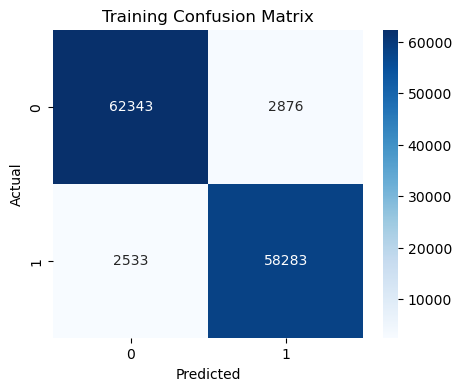


--- Test Metrics ---
Accuracy : 0.9560839760068551
Precision: 0.9523739382334168
Recall   : 0.9568370165745856
F1-score : 0.9546002608331898

Classification Report:
               precision    recall  f1-score   support

           0     0.9596    0.9554    0.9575     21740
           1     0.9524    0.9568    0.9546     20272

    accuracy                         0.9561     42012
   macro avg     0.9560    0.9561    0.9560     42012
weighted avg     0.9561    0.9561    0.9561     42012



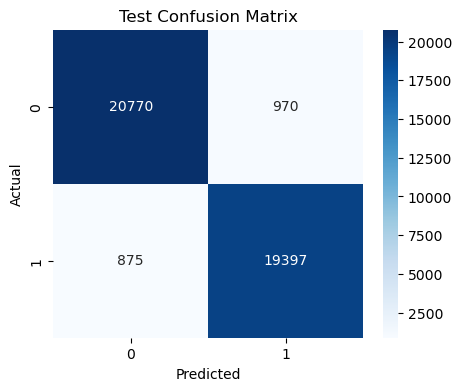


--- Validation Metrics ---
Accuracy : 0.9559173569456346
Precision: 0.9513844645920118
Recall   : 0.9575790460218024
F1-score : 0.9544717046069128

Classification Report:
               precision    recall  f1-score   support

           0     0.9602    0.9544    0.9573     21739
           1     0.9514    0.9576    0.9545     20273

    accuracy                         0.9559     42012
   macro avg     0.9558    0.9560    0.9559     42012
weighted avg     0.9559    0.9559    0.9559     42012



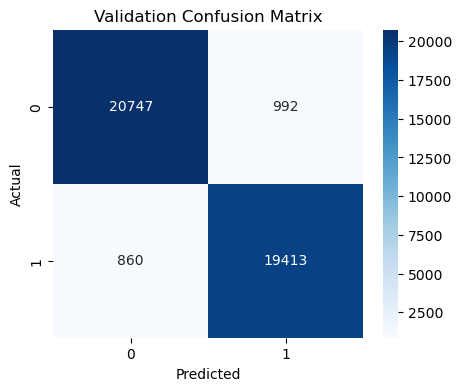

 Model saved at ./runs_models/run_7/svm_2_v6.pkl


In [22]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

#trying to see if loading works
X_train = np.load('./vectorizations/sbert_v4/X_train_sbert.npy')
X_test  = np.load('./vectorizations/sbert_v4/X_test_sbert.npy')
X_val   = np.load('./vectorizations/sbert_v4/X_val_sbert.npy')

y_train = np.load('./vectorizations/sbert_v4/y_train_sbert.npy')
y_test  = np.load('./vectorizations/sbert_v4/y_test_sbert.npy')
y_val   = np.load('./vectorizations/sbert_v4/y_val_sbert.npy')

print("Shapes:")
print("Train:", X_train.shape)
print("Test:", X_test.shape)
print("Val:", X_val.shape)


svm_2 = LinearSVC(
    C=1.0,              
    max_iter=5000,     
    random_state=42
)


print("Training LinearSVC on SBERT embeddings...")
svm_2.fit(X_train, y_train)
print("Training complete!")

# === Predictions ===
y_train_pred = svm_2.predict(X_train)
y_test_pred  = svm_2.predict(X_test)
y_val_pred   = svm_2.predict(X_val)

# === Metrics function ===
def print_metrics(y_true, y_pred, dataset_name="Dataset"):
    print(f"\n--- {dataset_name} Metrics ---")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1-score :", f1_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.show()

# === Evaluate ===
print_metrics(y_train, y_train_pred, "Training")
print_metrics(y_test, y_test_pred, "Test")
print_metrics(y_val, y_val_pred, "Validation")


joblib.dump(svm_2, "./runs_models/run_7/svm_2_v6.pkl")
print(" Model saved at ./runs_models/run_7/svm_2_v6.pkl")

[Almost identical! no overfitting most likely, great accuracy]